In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte


**Labels**

Each training and test example is assigned to one of the following labels:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

**INTRODUCTION**

I will investigate here some of my fresh knowledge in Machine Learning. I plan to go trough:

1. Working on the raw data, without scaling it or touch it in other ways with algorithms:
    - logistic regression
    - K Neighbors
    - SVC
    - Random Forest
2. Scale the data with Standard Scaler and again use the algorithms from point 1.
3. Using the scaled data preprocess it with dimension reduction algorithms PCA and K-Means as well as cluster the data with DBSCAN and use the algorithms from point 1.
4. Visualize the data with t-SNE as well as with preprocess with PCA.
5. Fine-tuning the best models.
6. Test the fine-tuned algorithm on the Test Set.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

In [3]:
dtrain = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
dtest = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

In [4]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [5]:
print("Train shape:\n", dtrain.shape)
print("Test shape:\n", dtest.shape)

Train shape:
 (60000, 785)
Test shape:
 (10000, 785)


In [6]:
dtrain.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
dtrain['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [68]:
predict = 'label'

X = dtrain.drop([predict], axis=1)
y = dtrain[predict]

In [10]:
test = dtest.drop([predict], axis=1)
test_labels = dtest[predict]

In [ ]:
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

fig, axes = plt.subplots(8, 8, figsize = (25,25))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = dtrain.drop('label', axis=1).values[index].reshape(28,28)
        cloths = dtrain['label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

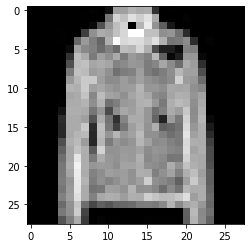

In [12]:
plt.imshow(X_train.iloc[0].values[0:].reshape(28, 28), cmap='gray')

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42000 entries, 7046 to 1835
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 251.5 MB


In [14]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

**PART 1**

Models without scale; raw data.

**Conclusion:**

After run all the algorithms its turn out that they they all get the scores from 0.83 till 0.88.

The best are SVC (0.88) and Random Forest (0.88). 

1.1. Logisitic regression

In [15]:
# log_reg = LogisticRegression(max_iter=100000)
# log_reg.fit(X_train, y_train)

# predictions_logreg = log_reg.predict(X_test)

# class_report_logreg = classification_report(y_test, predictions_logreg)
# print("Log Reg classification report:\n", class_report_logreg)

Log Reg classification report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      1783
           1       0.91      0.95      0.93      1795
           2       0.75      0.76      0.75      1814
           3       0.82      0.84      0.83      1822
           4       0.73      0.76      0.74      1805
           5       0.91      0.90      0.90      1738
           6       0.64      0.57      0.60      1846
           7       0.90      0.91      0.91      1841
           8       0.91      0.92      0.91      1762
           9       0.92      0.92      0.92      1794

    accuracy                           0.83     18000
   macro avg       0.83      0.83      0.83     18000
weighted avg       0.83      0.83      0.83     18000

1.2. KNN

In [16]:
# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_train, y_train)

# predictions_knn = knn.predict(X_test)

# class_report_knn = classification_report(y_test, predictions_knn)
# print("KNN classification report:\n", class_report_knn)

KNN classification report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      1783
           1       0.99      0.96      0.97      1795
           2       0.73      0.81      0.77      1814
           3       0.88      0.87      0.88      1822
           4       0.78      0.76      0.77      1805
           5       0.99      0.82      0.90      1738
           6       0.67      0.57      0.62      1846
           7       0.88      0.96      0.92      1841
           8       0.98      0.95      0.97      1762
           9       0.90      0.97      0.93      1794

    accuracy                           0.85     18000
   macro avg       0.86      0.85      0.85     18000
weighted avg       0.86      0.85      0.85     18000

1.3. SVC

In [17]:
# svc_class = SVC(C=1)
# svc_class.fit(X_train, y_train)

# predictions_svc = svc_class.predict(X_test)

# class_report_svc = classification_report(y_test, predictions_svc)
# print("SVC classification report:\n", class_report_svc)

    SVC classification report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      1783
           1       0.99      0.96      0.98      1795
           2       0.81      0.83      0.82      1814
           3       0.86      0.91      0.88      1822
           4       0.80      0.82      0.81      1805
           5       0.95      0.95      0.95      1738
           6       0.74      0.64      0.69      1846
           7       0.93      0.95      0.94      1841
           8       0.97      0.98      0.97      1762
           9       0.97      0.96      0.96      1794

    accuracy                           0.88     18000
   macro avg       0.88      0.88      0.88     18000
weighted avg       0.88      0.88      0.88     18000

1.4. Random Forest

In [18]:
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_train, y_train)

# predictions_rf = rf.predict(X_test)

# class_report_rf = classification_report(y_test, predictions_rf)
# print("Random Forest classification report:\n", class_report_rf)

Random Forest classification report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1783
           1       0.99      0.96      0.98      1795
           2       0.79      0.82      0.80      1814
           3       0.86      0.91      0.88      1822
           4       0.76      0.82      0.79      1805
           5       0.96      0.96      0.96      1738
           6       0.74      0.57      0.64      1846
           7       0.94      0.94      0.94      1841
           8       0.96      0.98      0.97      1762
           9       0.96      0.96      0.96      1794

    accuracy                           0.88     18000
   macro avg       0.88      0.88      0.88     18000
weighted avg       0.88      0.88      0.87     18000

****PART 2****

Data scaled with Standard Scaler.

**Conclusion:**

Scaling the data with Standard Scaler get slightly better results for each algorithm (about 0.1). For Random forest there is no change due to the characteristic of that algorithm.

Still the best are SVC (0.89) and Random Forest (0.88).

2.1. Logistic Regression

In [19]:
# log_reg = LogisticRegression(max_iter=100000)
# log_reg.fit(X_train_scaled, y_train)

# predictions_logreg = log_reg.predict(X_test_scaled)

# class_report_logreg = classification_report(y_test, predictions_logreg)
# print("Log Reg scaled classification report:\n", class_report_logreg)

Log Reg scaled classification report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      1800
           1       0.95      0.97      0.96      1800
           2       0.75      0.75      0.75      1800
           3       0.83      0.84      0.83      1800
           4       0.75      0.77      0.76      1800
           5       0.93      0.92      0.93      1800
           6       0.63      0.58      0.60      1800
           7       0.91      0.92      0.92      1800
           8       0.92      0.91      0.92      1800
           9       0.93      0.93      0.93      1800

    accuracy                           0.84     18000
   macro avg       0.84      0.84      0.84     18000
weighted avg       0.84      0.84      0.84     18000

2.2. KNN

In [20]:
# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_train_scaled, y_train)

# predictions_knn = knn.predict(X_test_scaled)

# class_report_knn = classification_report(y_test, predictions_knn)
# print("KNN scaled classification report:\n", class_report_knn)

KNN scaled classification report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82      1800
           1       0.99      0.96      0.98      1800
           2       0.76      0.79      0.78      1800
           3       0.89      0.86      0.87      1800
           4       0.76      0.77      0.76      1800
           5       0.99      0.82      0.90      1800
           6       0.67      0.61      0.64      1800
           7       0.87      0.96      0.91      1800
           8       0.98      0.93      0.96      1800
           9       0.90      0.96      0.93      1800

    accuracy                           0.85     18000
   macro avg       0.86      0.85      0.85     18000
weighted avg       0.86      0.85      0.85     18000

2.3. SVC

In [21]:
# svc_class = SVC(C=1)
# svc_class.fit(X_train_scaled, y_train)

# predictions_svc = svc_class.predict(X_test_scaled)

# class_report_svc = classification_report(y_test, predictions_svc)
# print("SVC scaled classification report:\n", class_report_svc)

SVC scaled classification report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1800
           1       0.99      0.97      0.98      1800
           2       0.82      0.82      0.82      1800
           3       0.87      0.90      0.89      1800
           4       0.80      0.84      0.82      1800
           5       0.97      0.96      0.97      1800
           6       0.74      0.65      0.69      1800
           7       0.94      0.95      0.95      1800
           8       0.95      0.97      0.96      1800
           9       0.96      0.95      0.95      1800

    accuracy                           0.89     18000
   macro avg       0.89      0.89      0.89     18000
weighted avg       0.89      0.89      0.89     18000

2.4. Random Forest

In [22]:
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_train_scaled, y_train)

# predictions_rf = rf.predict(X_test_scaled)

# class_report_rf = classification_report(y_test, predictions_rf)
# print("Random Forest scaled classification report:\n", class_report_rf)

Random Forest scaled classification report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      1800
           1       0.99      0.96      0.98      1800
           2       0.78      0.81      0.80      1800
           3       0.88      0.91      0.90      1800
           4       0.76      0.83      0.79      1800
           5       0.97      0.96      0.96      1800
           6       0.74      0.59      0.66      1800
           7       0.94      0.94      0.94      1800
           8       0.97      0.97      0.97      1800
           9       0.95      0.95      0.95      1800

    accuracy                           0.88     18000
   macro avg       0.88      0.88      0.88     18000
weighted avg       0.88      0.88      0.88     18000

**PART 3**

Preprocessing with dimensions reduction by PCA and K-Means with scaled data.

**Conclusion:**

The dimension reduction achieved by the variance of 0.95 is 255 features.

The influence of the reduced data slightly improved the performance of KNN to 0.86 but had no infuence on other algorithms, in case of Random Forest the score fall down.

Clustering with K-Means didn't change a lot. Actually all the algorithms perfom worste as without clustering. I checked some values of n_clusters but only logistic regression seems to be affected to it but still the scores are not better than with no clustering. 

I wanted to try a bigger range of n_clusters using GridSearchCV but it turn out to be very slow in computing so I had to give it up.

DBSCAN couldn't find any clusters only noise. There were no good parameter eps or min_samples to build clusters. 

3.1. PCA

In [23]:
# n_comps = 0.95
# pca = PCA(n_components=n_comps)
# X_train_reduced = pca.fit_transform(X_train_scaled)
# X_test_reduced = pca.transform(X_test_scaled)

# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum >= n_comps) + 1

In [24]:
# print("For the deserved ratio of variance {n_comps} the number of principal components is:\n", d)

The number is 255

In [25]:
# plt.figure(figsize=(6,4))
# plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])
# plt.xlabel("Dimensions")
# plt.ylabel("Explained Variance")
# plt.plot([d, d], [0, 0.95], "k:")
# plt.plot([0, d], [0.95, 0.95], "k:")
# plt.plot(d, 0.95, "ko")
# plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
#              arrowprops=dict(arrowstyle="->"), fontsize=16)
# plt.grid(True)
# plt.show()

In [26]:
pca = PCA(n_components=255)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

3.1.1. Logistic Regression with PCA

In [27]:
# log_reg = LogisticRegression(max_iter=100000)
# log_reg.fit(X_train_reduced, y_train)

# predictions_logreg = log_reg.predict(X_test_reduced)

# class_report_logreg = classification_report(y_test, predictions_logreg)
# print("Log Reg reduced classification report:\n", class_report_logreg)

Log Reg reduced classification report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      1800
           1       0.97      0.97      0.97      1800
           2       0.76      0.75      0.76      1800
           3       0.84      0.87      0.85      1800
           4       0.74      0.78      0.76      1800
           5       0.95      0.94      0.94      1800
           6       0.65      0.59      0.62      1800
           7       0.92      0.94      0.93      1800
           8       0.95      0.94      0.94      1800
           9       0.95      0.94      0.95      1800

    accuracy                           0.85     18000
   macro avg       0.85      0.85      0.85     18000
weighted avg       0.85      0.85      0.85     18000

3.1.2. KNN with PCA

In [28]:
# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_train_reduced, y_train)

# predictions_knn = knn.predict(X_test_reduced)

# class_report_knn = classification_report(y_test, predictions_knn)
# print("KNN reduced classification report:\n", class_report_knn)

KNN reduced classification report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      1800
           1       0.99      0.97      0.98      1800
           2       0.78      0.79      0.78      1800
           3       0.89      0.87      0.88      1800
           4       0.75      0.79      0.77      1800
           5       0.98      0.87      0.92      1800
           6       0.67      0.61      0.64      1800
           7       0.90      0.96      0.93      1800
           8       0.98      0.94      0.96      1800
           9       0.91      0.96      0.94      1800

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000

3.1.3. SVC with PCA

In [29]:
# svc_class = SVC(C=1)
# svc_class.fit(X_train_reduced, y_train)

# predictions_svc = svc_class.predict(X_test_reduced)

# class_report_svc = classification_report(y_test, predictions_svc)
# print("SVC reduced classification report:\n", class_report_svc)

SVC reduced classification report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1800
           1       0.99      0.97      0.98      1800
           2       0.82      0.81      0.81      1800
           3       0.87      0.90      0.89      1800
           4       0.80      0.84      0.82      1800
           5       0.97      0.96      0.96      1800
           6       0.74      0.65      0.69      1800
           7       0.93      0.95      0.94      1800
           8       0.95      0.97      0.96      1800
           9       0.96      0.95      0.95      1800

    accuracy                           0.89     18000
   macro avg       0.89      0.89      0.89     18000
weighted avg       0.89      0.89      0.89     18000

3.1.4. Random Forest with PCA

In [30]:
# rf = RandomForestClassifier(random_state=42)
# rf.fit(X_train_reduced, y_train)

# predictions_rf = rf.predict(X_test_reduced)

# class_report_rf = classification_report(y_test, predictions_rf)
# print("Random Forest reduced classification report:\n", class_report_rf)

Random Forest reduced classification report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      1800
           1       0.99      0.96      0.98      1800
           2       0.78      0.79      0.79      1800
           3       0.85      0.89      0.87      1800
           4       0.75      0.82      0.78      1800
           5       0.93      0.91      0.92      1800
           6       0.73      0.55      0.63      1800
           7       0.92      0.91      0.91      1800
           8       0.92      0.96      0.94      1800
           9       0.92      0.95      0.93      1800

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000

3.2. K-Means

3.2.1. Log Reg with K-Means

In [31]:
'''Takes way to much time to compute'''

# pipeline_logreg_kmeans = Pipeline([("kmeans", KMeans(n_clusters=50)), ("log_reg", LogisticRegression(max_iter=1000000, n_jobs=-1))])

# param_grid_logreg_kmeans = dict(kmeans__n_clusters=range(2, 100))
# grid_logreg_kmeans = GridSearchCV(pipeline_logreg_kmeans, param_grid_logreg_kmeans, cv=10, verbose=2)
# grid_logreg_kmeans.fit(X_train_scaled, y_train)

# print("SVC - Best params:\n", grid_logreg_kmeans.best_params_)
# print("SVC - Best cross-validation score:\n", grid_logreg_kmeans.best_score_)
# print("SVC - Test score:\n", grid_svc.score(X_test_scaled, y_test))

'Takes way to much time to compute'

In [32]:
# pipeline = Pipeline([("kmeans", KMeans(n_clusters=200)), ("log_reg", LogisticRegression(max_iter=1000000, n_jobs=-1))])
# pipeline.fit(X_train_scaled, y_train)

# pipeline.score(X_test_scaled, y_test)

n_clusters=50, 0.8223333333333334

n_clusters=100, 0.8430555555555556

n_clusters=150, 0.8523888888888889

n_clusters=200, 0.8548888888888889

3.2.2. KNN with K-Means

In [33]:
# pipeline_knn = Pipeline([("kmeans", KMeans(n_clusters=100)), ("knn", KNeighborsClassifier(n_neighbors=7, n_jobs=-1))])
# pipeline_knn.fit(X_train_scaled, y_train)

# pipeline_knn.score(X_test_scaled, y_test)

n_clusters=50, 0.7940555555555555

n_clusters=100, 0.803

3.2.3. SVC with K-Means

In [34]:
# pipeline_svc = Pipeline([("kmeans", KMeans(n_clusters=100)), ("svc", SVC(C=1))])
# pipeline_svc.fit(X_train_scaled, y_train)

# pipeline_svc.score(X_test_scaled, y_test)

n_clusters=50, 0.7764444444444445
n_clusters=100, 0.7781666666666667

3.2.4. Random Forest with K-Mean

In [35]:
# pipeline_rf = Pipeline([("kmeans", KMeans(n_clusters=100)), ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))])
# pipeline_rf.fit(X_train, y_train)

# pipeline_rf.score(X_test, y_test)

n_clusters=50, 0.8048333333333333

n_clusters=100, 0.8152777777777778

3.3. DBSCAN

In [36]:
'''DBSCAN finds no clusters at all; tryied many hyperparameters. No results!'''

# dbscan = DBSCAN(eps=0.05, min_samples=5)
# dbscan.fit(X_train_scaled)
# print("dbscan labels:\n",dbscan.labels_)
# print("lenght core sample indices:\n",len(dbscan.core_sample_indices_))
# print("core smape indices:\n", dbscan.core_sample_indices_)
# print("components:\n", dbscan.components_)

# knn_dbscan = KNeighborsClassifier(n_neighbors=50)
# knn_dbscan.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

# knn_dbscan.predict(X_test_scaled)

# plt.figure(figsize=(15, 15))
# plot_decision_boundaries(knn_dbscan, X_train_scaled, show_centroids=False)
# plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c="b", marker="+", s=200, zorder=10)
# plt.show()

'DBSCAN finds no clusters at all; tryied many hyperparameters. No results!'

**PART 4**

Using t-SNE to visualize the dataset.

In [37]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):
        
        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

t-SNE reduction

In [38]:
# tsne = TSNE(random_state=42)
# # use fit_transform instead of fit, as TSNE has no transform method
# fashion_tsne = tsne.fit_transform(X_train_scaled)

t-SNE visualization

In [39]:
# fashion_scatter(fashion_tsne, y_train)

t-SNE reduction with pre-reduction with PCA

In [40]:
# tsne_pca = TSNE(random_state=42)
# fashion_tsne_pca = tsne_pca.fit_transform(X_train_reduced)

t-SNE with PCA reduction visualization

In [41]:
# fashion_scatter(fashion_tsne_pca, y_train)

**PART 5**

Fine tuning with gridsearch for best models. In my opinion the best are SVC on PCA reduced data as well as Random Forest on raw data.

**Conclusion:**

The error analysis for Random Forest shows that most of the errors happened by the category 6 which is shirt. HERE I PLOT SOME SHIRTS TO CHECK THE PHOTOS: 
The averaged ROC-AUC-Score both OVO and OVR is quite good with 0.977. 

The error analysis for SVC on PCA reduced data was very expensive in computing. It was not possible to get ROC AUC due to an error and it was frustrating to wait many hours one more time to compute all. But still the confucion matrix and errors visualization was done, well kind of.

5.1. SVC on scaled data

In [42]:
'''Impossible to compute, take way to much time'''
# svc_class = SVC()

# param_grid_svc = [{'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100]
#                   }]

# grid_svc = GridSearchCV(svc_class, param_grid_svc, cv=10)
# grid_svc.fit(X_train_reduced, y_train)

# print("SVC - Best params:\n", grid_svc.best_params_)
# print("SVC - Best cross-validation score:\n", grid_svc.best_score_)
# print("SVC - Test score:\n", grid_svc.score(X_test_reduced, y_test))

'Impossible to compute, take way to much time'

5.1.1. SVC Error analysis

SVC with best params from GridsearchCV:

In [43]:
'''Impossible to compute, take way to much time'''
# svc_best = SVC(C=0.1, gamma=10, probability=True)
# svc_train_prediction = cross_val_predict(svc_best, X_train_reduced, y_train, cv=5)

'Impossible to compute, take way to much time'

[](http://)SVC - Confusion matrix

In [44]:
# conf_mx_svc = confusion_matrix(y_train, svc_train_prediction)
# conf_mx_svc

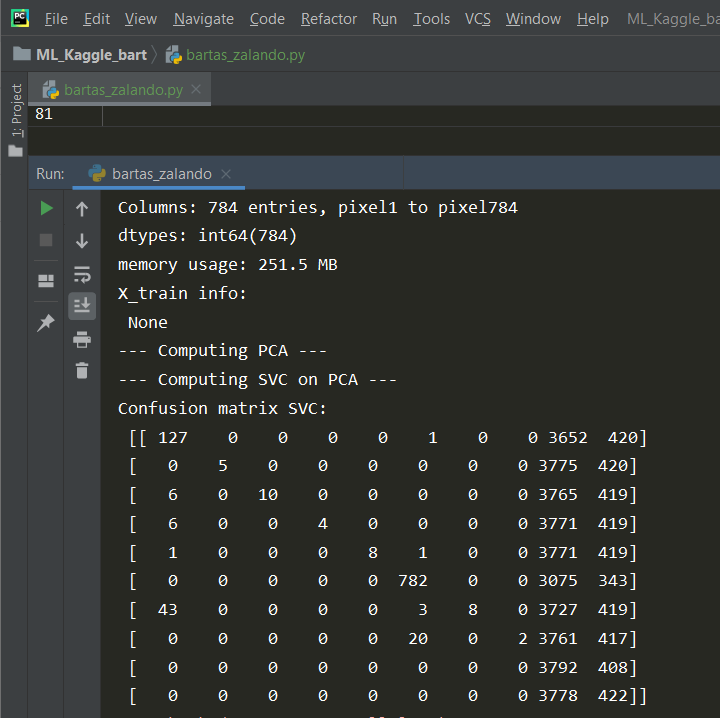

The confusion matrix seems to be totaly craped.

SVC - Visualization of confusion matrix

In [45]:
# plt.matshow(conf_mx_svc, cmap=plt.cm.gray)
# plt.show()

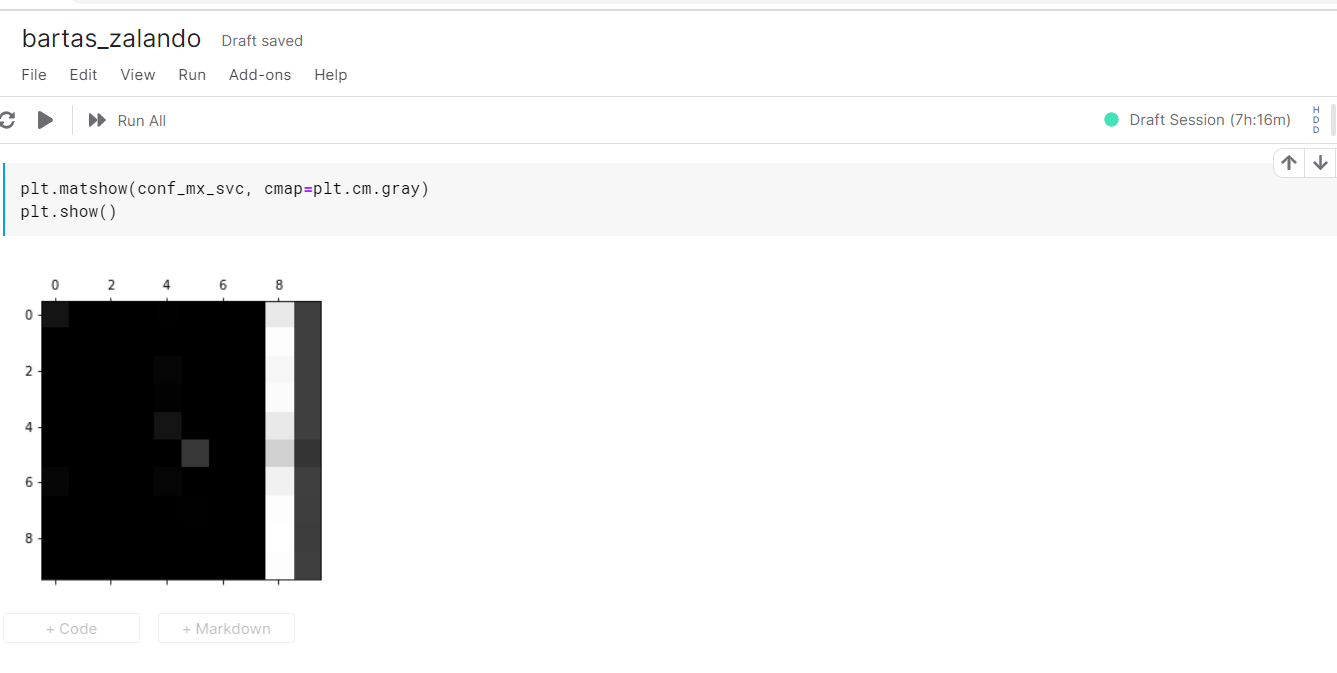

SVC - Let´s divide each value in the confusion matrix by the number of images in the corresponding class to compare
error rates instead of absolute number of errors.

In [46]:
# row_sums_svc = conf_mx_svc.sum(axis=1, keepdims=True)
# norm_conf_mx_svc = conf_mx_svc / row_sums_svc

SVC - Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:

In [47]:
# np.fill_diagonal(norm_conf_mx_svc, 0)
# plt.matshow(norm_conf_mx_svc, cmap=plt.cm.gray)
# plt.show()

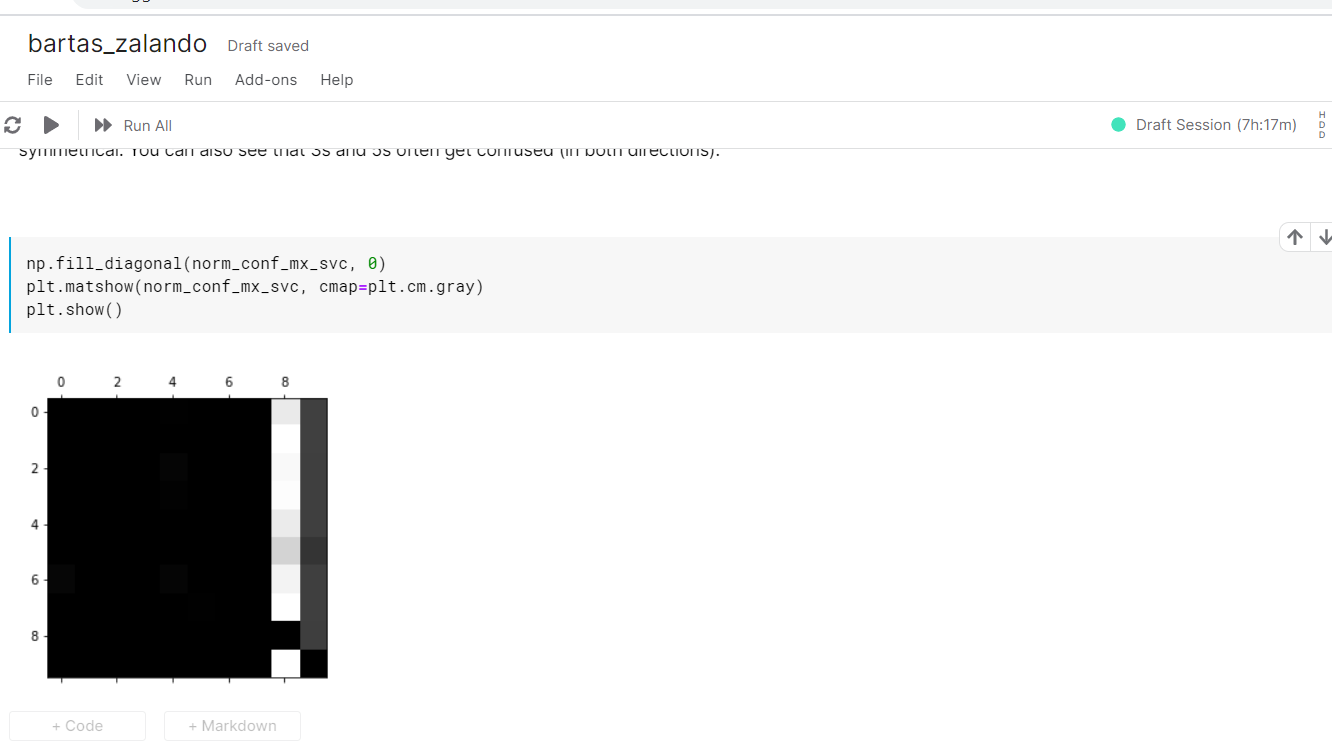

In [48]:
# svc_best.fit(X_train_reduced, y_train)
# prediction_ = svc_best.predict(X_test_reduced)

SVC - ROC AUC Score

In [49]:
# y_scores_svc = svc_best.predict_proba(X_test_reduced)

# r_a_score_svc = roc_auc_score(y_test, y_scores_svc)
# print("SVC best - ROC-AUC-Score:", r_a_score_svc)

5.2. Random Forest on raw data

In [50]:
# rf = RandomForestClassifier()

# param_grid_rf = [{'max_features': [2, 3, 4, 5],
#                'max_depth': [3, 4, 5, 6, 7],
#                'n_estimators': [10, 50, 100, 200, 500]
#               }]

# grid_rf = GridSearchCV(rf, param_grid_rf, cv=10)
# grid_rf.fit(X_train, y_train)
# print("RF - Best params:\n", grid_rf.best_params_)
# print("RF - Best cross-validation score:\n", grid_rf.best_score_)
# print("RF - Test score:\n", grid_rf.score(X_test, y_test))

RF - Best params:
 {'max_depth': 7, 'max_features': 5, 'n_estimators': 500}

RF - Best cross-validation score:
 0.8017142857142858

RF - Test score:
 0.8006111111111112

5.2.1. RF Error analysis

RF - Confusion matrix

In [51]:
rf_best = RandomForestClassifier(max_depth=7, max_features=5)
rf_train_prediction = cross_val_predict(rf_best, X_train, y_train, cv=10)
conf_mx_rf = confusion_matrix(y_train, rf_train_prediction)
conf_mx_rf

array([[3400,    2,   95,  480,   28,    4,  124,    0,   67,    0],
       [  14, 3899,   75,  179,   19,    0,   11,    0,    3,    0],
       [  24,    1, 3052,   42,  863,    1,  179,    0,   38,    0],
       [ 137,   17,   48, 3746,  140,    0,  101,    0,   11,    0],
       [  11,   11,  644,  431, 2941,    1,  130,    0,   31,    0],
       [   0,    0,    0,    3,    1, 3570,    0,  452,   25,  149],
       [1005,    6,  764,  296,  721,    3, 1285,    0,  120,    0],
       [   0,    0,    0,    0,    0,   56,    0, 3781,    3,  360],
       [   8,    3,   71,   49,   19,   15,   18,   21, 3989,    7],
       [   0,    0,    2,    2,    0,   38,    0,  226,    9, 3923]])

RF - Visualization of confusion matrix

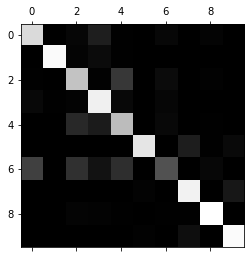

In [52]:
plt.matshow(conf_mx_rf, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks quite good, since most images are on the main diagonal, which means that they were classified correctly, still there are some outside (missclassified). The 6 class (shirt) looks darker than the others, which could mean that the classifier does not perform as well on that class as on others. The images outside the diagonal are clear missclassifications.

RF - Error rates

In [53]:
row_sums = conf_mx_rf.sum(axis=1, keepdims=True)
norm_conf_mx_rf = conf_mx_rf / row_sums

RF - Visualization of error rates

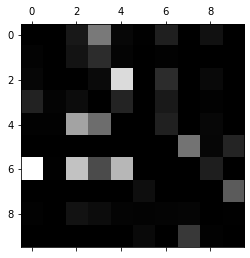

In [54]:
np.fill_diagonal(norm_conf_mx_rf, 0)
plt.matshow(norm_conf_mx_rf, cmap=plt.cm.gray)
plt.show()

RF - ROC AUC Score

Now we can clearly see the kinds of errors the classifier makes. 

The rows represent actual classes, while columns represent predicted classes. 

The column for classes 2, 3 and 4 are quite bright, which tells you that many images get misclassified as classes 2, 3 or 4. However, the row for class 3 is not that bad, telling you that actual class 3 in general get properly classified as that class. The row for class 6 looks fairly bad whisch means many shirts(class 6) were missclassified as others.

In [55]:
rf_best.fit(X_train, y_train)
prediction_rf = rf_best.predict(X_test)

In [56]:
y_scores_rf = rf_best.predict_proba(X_test)

r_a_score_rf = roc_auc_score(y_test, y_scores_rf, multi_class='ovo')
print("RF best - ROC-AUC-Score OVO:", r_a_score_rf)

RF best - ROC-AUC-Score OVO: 0.9770483264746225


RF best - ROC-AUC-Score: 0.9772588648834019

In [57]:
r_a_score_rf_ovr = roc_auc_score(y_test, y_scores_rf, multi_class='ovr')
print("RF best - ROC-AUC-Score OVR:", r_a_score_rf_ovr)

RF best - ROC-AUC-Score OVR: 0.9770483264746227


RF best - ROC-AUC-Score OVR: 0.977258864883402

In [99]:
precision, recall, _ = precision_recall_curve(y_test, y_scores_rf)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

ValueError: multiclass format is not supported

In [98]:
# precision recall curve
n_classes = len(set(y_test))
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_scores_rf[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

ValueError: Can only tuple-index with a MultiIndex

**PART 6**

Testing model on the Test Set.

FINAL CONCLUSION:

As we could see there is no gut result none algorithm. I tryied four different algorthms on the raw data, scaled data, reduced data. None of these approaches could find a satisfying result. The choosen model based on Random Forest provide a not bad accuracy (almost 8000 from 10000 test set labels were classified correctly). Additionaly 

In [62]:
rf_best.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [63]:
prediction_test = rf_best.predict(test)

In [65]:
class_report_rf_test = classification_report(test_labels, prediction_test)
print("Random Forest raw classification report on TEST:\n", class_report_rf_test)

Random Forest raw classification report on TEST:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76      1000
           1       0.98      0.93      0.95      1000
           2       0.65      0.74      0.69      1000
           3       0.71      0.90      0.79      1000
           4       0.63      0.71      0.67      1000
           5       0.97      0.85      0.90      1000
           6       0.75      0.30      0.43      1000
           7       0.83      0.87      0.85      1000
           8       0.92      0.95      0.94      1000
           9       0.85      0.92      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000



Random Forest raw classification report on TEST:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76      1000
           1       0.98      0.93      0.95      1000
           2       0.65      0.74      0.69      1000
           3       0.71      0.90      0.79      1000
           4       0.63      0.71      0.67      1000
           5       0.97      0.85      0.90      1000
           6       0.75      0.30      0.43      1000
           7       0.83      0.87      0.85      1000
           8       0.92      0.95      0.94      1000
           9       0.85      0.92      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000

In [66]:
test_scores_rf = rf_best.predict_proba(test)

r_a_score_rf_test = roc_auc_score(test_labels, test_scores_rf, multi_class='ovo')
print("RF best - ROC-AUC-Score OVO on TEST:", r_a_score_rf_test)

RF best - ROC-AUC-Score OVO on TEST: 0.9767896444444443


RF best - ROC-AUC-Score OVO on TEST: 0.9767896444444443

In [87]:
# prediction_test = np.argmax(np.round(prediction_test),axis=1)
prediction_test.shape, test_labels.shape

((10000,), (10000,))

In [92]:
correct = np.where(prediction_test==test_labels)[0]
print ("Found correct labels:", len(correct))

Found correct labels: 7968
